* MNIST inverse network
* Newsgroups inverse network
* Squared error loss and classification loss
  * Also with L1 regularisation

In [1]:
import sys
import cPickle as pickle
import gzip
from matplotlib import pyplot as plt
%matplotlib inline
sys.path.append("../modules/")
import helper as hp
# ----
import theano
from theano import tensor as T
import lasagne
import numpy as np
np.random.seed(0)
# ---
from skimage import io
# ---
from lasagne.layers import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.init import *
from lasagne.updates import *
from lasagne.regularization import *

//anaconda/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [25]:
def conv_net():
    a_in = InputLayer( (None, 1, 28, 28) )
    a_conv1 = Conv2DLayer(a_in, num_filters=16, filter_size=(5,5), nonlinearity=tanh)
    a_mp1 = MaxPool2DLayer(a_conv1, pool_size=(2,2))
    a_conv2 = Conv2DLayer(a_mp1, num_filters=32, filter_size=(3,3), nonlinearity=tanh)
    a_mp2 = MaxPool2DLayer(a_conv2, pool_size=(2,2))
    a_fc1 = DenseLayer(a_mp2, num_units=32)
    a_inv = InverseLayer(a_fc1, a_fc1)
    a_inv2 = InverseLayer(a_inv, a_mp2)
    a_inv3 = InverseLayer(a_inv2, a_conv2)
    a_inv4 = InverseLayer(a_inv3, a_mp1)
    a_inv5 = InverseLayer(a_inv4, a_conv1)
    a_out = NonlinearityLayer(a_inv5, nonlinearity=sigmoid)
    
    X = T.tensor4('X')
    Y = T.tensor4('Y')

    lamb = 0.0
    loss = squared_error( get_output(a_out, X), Y ).mean()

    #regularize_layer_params(a_out, l1) * lamb
    params = get_all_params(a_out)
    updates = nesterov_momentum(loss, params, 0.01, 0.9)

    train_fn = theano.function([X, Y], loss, updates=updates)
    x_grad_fn = theano.function([X, Y], T.grad(loss, X))
    predict_fn = theano.function([X], get_output(a_out, X) )
    loss_fn = theano.function([X, Y], loss )
    
    return a_out, train_fn, x_grad_fn, predict_fn, loss_fn

In [12]:
def print_net(out):
    for layer in get_all_layers(out):
        print layer.output_shape
    print count_params(out)

In [13]:
a_out, train_fn, x_grad_fn, predict_fn, loss_fn = conv_net()

In [14]:
print_net(a_out)

(None, 1, 28, 28)
(None, 16, 24, 24)
(None, 16, 12, 12)
(None, 32, 10, 10)
(None, 32, 5, 5)
(None, 32)
(None, 32, 5, 5)
(None, 32, 10, 10)
(None, 16, 12, 12)
(None, 16, 24, 24)
(None, 1, 28, 28)
(None, 1, 28, 28)
30688


In [15]:
train_set, _, _ = hp.load_mnist()
Xt, yt = train_set
yt = np.asarray(yt, dtype="int32")

In [16]:
grads = []
for epoch in range(0, 1):
    b = 0
    batch_size = 128
    losses = []
    while True:
        if b*batch_size >= Xt.shape[0]:
            break
        this_loss = train_fn(Xt[b*batch_size : (b+1)*batch_size])
        losses.append(this_loss)
        b += 1
    print np.mean(losses)

0.20441667173


In [17]:
Xt_9 = Xt[ (yt == 9) ]
yt_9 = np.asarray([9 for x in range(0, Xt_9.shape[0])], dtype="int32")

In [28]:
Xt_9.shape

(4988, 1, 28, 28)

In [18]:
grads_for_xt9 = x_grad_fn(Xt_9)

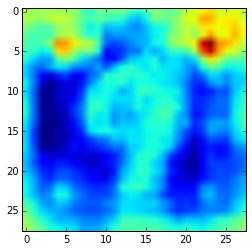

In [19]:
plt.imshow(np.mean(np.abs(grads_for_xt9),axis=0)[0])

In [26]:
a_out, train_fn, x_grad_fn, predict_fn, loss_fn = conv_net()

In [21]:
Xt_noise = np.random.uniform(0, 1, size=Xt.shape)

In [27]:
grads = []
for epoch in range(0, 1):
    b = 0
    batch_size = 128
    losses = []
    while True:
        if b*batch_size >= Xt.shape[0]:
            break
        this_loss = train_fn(
            Xt_noise[b*batch_size : (b+1)*batch_size], Xt[b*batch_size : (b+1)*batch_size])
        losses.append(this_loss)
        b += 1
    print np.mean(losses)

0.231131087935


In [30]:
grads_for_noise = x_grad_fn(Xt_noise[0:Xt_9.shape[0]], Xt_9)

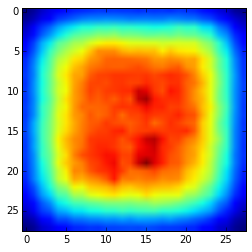

In [31]:
plt.imshow(np.mean(np.abs(grads_for_noise),axis=0)[0])

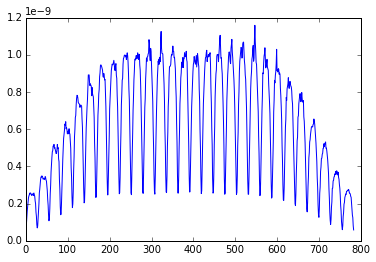

In [32]:
plt.plot( np.mean(np.abs(grads_for_noise),axis=0).flatten() )

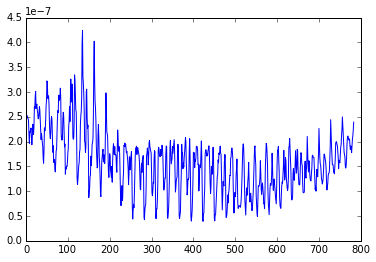

In [33]:
plt.plot( np.mean(np.abs(grads_for_xt9),axis=0).flatten() )